# Linear Models (Advanced)

မင်္ဂလာပါ။ Data Science Using Python Week 14 က ကြိုဆိုပါတယ်။ 

ဒီတပါတ်မှာ linear model တွေအကြောင်းကို အသေးစိတ် ပြောမှာ ဖြစ်ပါတယ်။

## Review of Linear Regression

---

### Recipe 10 - Linear Regression

**Regression**: ဆိုတာ ဂဏန်းတန်ဖိုးတခုကို တွက်နည်းကို မသိပဲ အရင်က အဖြေတွေကို သိထားတဲ့အခါကျရင် နောက် unseen အဖြေတွေကို ခန့်မှန်း/တွက်ချက်ပေးမဲ့ function (Model) ကို တည်ဆောက်ခြင်းပါ။

> လိုတာတွေကတော့ အရင်က $X$ (features/independent variables) နဲ့ အဖြေ $y$ (target/dependent variable) တွေပဲ။

> validation/test dataset ကို သပ်သပ်ဖယ်ထားလေ့ရှိတယ်။

```python
from sklearn import linear_model as sk_lm

# initializing the model;
linear_regression_model = sk_lm.LinearRegression()
# building the model; 
linear_regression_model.fit(X, y)
# using the model for unseen values
y_pred = linear_regression_model.predict(X_unseen)
```

---

## Inner-workings of Linear Regression

In [ ]:
import numpy as np
from scipy import linalg as sp_linalg, optimize as sp_optimize

import pandas as pd
from sklearn import datasets, metrics, linear_model, model_selection as ms

In [95]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
import importlib
import utils
importlib.reload(utils)

np.random.seed(42)

In [ ]:
df_X, ds_y = datasets.fetch_california_housing(return_X_y=True, as_frame=True)
df_X.head()

In [ ]:
N = len(ds_y)
k_select_every = 50
selected_col = "MedInc"

In [ ]:
selector = range(0, N, k_select_every)
selected_X = df_X[selected_col][selector]
selected_y = ds_y[selector]
utils.scatter_xy(selected_X, y=selected_y, xlabel=selected_col)

In [ ]:
model = linear_model.LinearRegression()
model.fit(selected_X.values.reshape((-1, 1)), selected_y)
model.coef_, model.intercept_

#### **အဲဒီ အပေါ်က ဂဏန်း ၂ လုံး ဘယ်က ရလာသလဲ**

In [ ]:
utils.scatter_xy(selected_X, y=selected_y, xlabel=selected_col)
utils.draw_line(model.coef_[0], model.intercept_, ylim=(0, 5.5))
plt.show()

လိုင်း အနီဟာ ဂဏန်း ၂ လုံးကို ကိုယ်စားပြုတယ်။ `model` ရဲ့ `predict` function ဟာ အောက်ပါ function နဲ့ တူတူပဲ ဖြစ်တယ်။

```python
def predict(x, coef_=model.coef_[0], intercept_=model.intercept_):
    return x * coef_ + intercept_
```

In [ ]:
def predict(x, coef_=model.coef_[0], intercept_=model.intercept_):
    return x * coef_ + intercept_
predict(selected_X)

In [ ]:
# fix this error
temp_df = pd.DataFrame({
    selected_col : selected_X, 
    "predict_function" : predict(selected_X),
    "model_predict_function" : model.predict(selected_X.values.reshape((-1, 1))),
})
temp_df

အဖြစ်မှန်နဲ့ `model` output နဲ့ ကွာခြားချက်ကို သိစေဖို့ `error` ကို `predict_function` ထဲက `selected_y` ကို နှုတ်ပြီး ရှာကြည့်ကြမယ်။ 

ပြီးတော့ အဲဒီ `error` ကို အမြဲ အပေါင်းကိန်းဖြစ်စေဖို့ ၂ ထပ် တင်လိုက်မယ်။

In [ ]:
temp_df["error"] = temp_df["predict_function"] - selected_y
temp_df["square_error"] = temp_df["error"].values ** 2
temp_df

In [ ]:
def calculate_sum_square_error(predict, actual):
    return np.sum((predict - actual) ** 2)

calculate_sum_square_error(temp_df["predict_function"], selected_y)

အခု `coef_` value 5 ခုနဲ့ `intercept_` value 5 ခုတို့ရဲ့ လိုင်းတွေကို ဆွဲကြည့်ပြီး သူတို့ရဲ့ sum_square_error ကို တွက်ကြည့်ကြစို့။

In [ ]:
_, ax = plt.subplots(nrows=5, ncols=5)
error = np.zeros((5, 5))
values = list(range(-2, +3, 1))
for r_idx, (c, _plt_row) in enumerate(zip(values, ax)):
    for c_idx, (i, _plt) in enumerate(zip(values, _plt_row)):
        utils.draw_line(c, i, xlim=(-14, 14), ylim=(-5.5, 5.5), subplot=_plt)
        error[r_idx, c_idx] = calculate_sum_square_error(
            predict(selected_X, c, i),
            selected_y
        )
plt.show()
print (np.around(error, decimals=4))

#### Now, the problem becomes:


Given a set of bounds such that:

$- \infty \leq \text{coef} \leq + \infty$ and $- \infty \leq \text{intercept} \leq + \infty$, 

to **minimize** a function $z(\text{coef}, \text{intercept})$ defined as: 

```python
def z(_X):
    c, i = _X
    y_pred = predict(selected_X, coef_=c, intercept_=i)
    return calculate_sum_square_error(y_pred, selected_y)
```

**Recipe 4 - Minimizing Non-Linear Functions** says, 

> `scipy.optimize` ထဲက `minimize` function ကိုသုံးပြီး ရှင်းပါ။

In [ ]:
def z(_X):
    c, i = _X
    y_pred = predict(selected_X, coef_=c, intercept_=i)
    return calculate_sum_square_error(y_pred, selected_y)

bounds = ((-np.inf, np.inf), (-np.inf, np.inf))

results = sp_optimize.minimize(fun=z, x0=[0.3, 0.3], bounds=bounds)
results

#### But, what about **Regularization** ?

In [63]:
l1_ratio = 0.15
def z_with_regularization(_X):
    c, i = _X
    y_pred = predict(selected_X, coef_=c, intercept_=i)
    l1_weight = abs(c)
    l2_weight = c ** 2
    return calculate_sum_square_error(y_pred, selected_y) + l1_ratio * l1_weight + (1 - l1_ratio) * l2_weight

bounds = ((-np.inf, np.inf), (-np.inf, np.inf))

results = sp_optimize.minimize(fun=z_with_regularization, x0=[0.3, 0.3], bounds=bounds)
results

      fun: 270.89623216419875
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686838e-05, 5.68434189e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 4
   status: 0
  success: True
        x: array([0.42480717, 0.41289775])

## Review of Logistic Regression

---

### Recipe 16 - **Classification** with Linear Models

**Classification**: ဆိုတာ category (class) ခွဲနည်းကို မသိပဲ အရင်က အဖြေတွေကို သိထားတဲ့အခါကျရင် နောက် unseen အဖြေတွေကို ခန့်မှန်း/တွက်ချက်ပေးမဲ့ function (Model) ကို တည်ဆောက်ခြင်းဖြစ်တယ်။

> လိုတာတွေကတော့ အရင်က $X$ (features/independent variables) နဲ့ အဖြေ $y$ (target/dependent variable) တွေပဲ။

> validation/test dataset ကို သပ်သပ်ဖယ်ထားလေ့ရှိတယ်။

```python
from sklearn import linear_model as sk_lm

# building the model; check closely these 3 lines
linear_regression_model = sk_lm.LogisticRegression()
linear_regression_model.fit(X, y)

# for unseen values
y_pred = linear_regression_model.predict(X_unseen)
```

---

### Inner-workings of Logistic Regression

In [88]:
df_X, ds_y = datasets.load_digits(n_class=2, return_X_y=True, as_frame=True)
ds_y.astype(dtype=np.int8)
ds_y.describe()

count    360.000000
mean       0.505556
std        0.500665
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [70]:
from sklearn import feature_selection
selector = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=1)
selector.fit(df_X.values, ds_y)
features = selector.transform(df_X.values)
features.shape

In [89]:
model = linear_model.LogisticRegression()
model.fit(features, ds_y)
model.coef_, model.intercept_

(array([[1.59644402]]), array([-4.35837193]))

#### ပြဿနာ ၂ ခု 

1. Linear Regression လိုပဲ minimize လို့မရဘူး။ တချို့ တန်ဖိုးတွေက 0 ထက် ငယ်ပြီး တချို့က 1 ထက်ကြီးနေတယ်။

In [93]:
print (np.max(features), np.max(predict(features, model.coef_[0], model.intercept_)))
print (np.min(features), np.min(predict(features, model.coef_[0], model.intercept_)))

16.0 21.184732450133488
0.0 -4.358371928662804


ဒါကြောင့် ဒီနေရာမှာ $log(\text{odd})$ ကို သုံးရတယ်။ 

**odd** အကြောင်းလေး နည်းနည်း ရှင်းပြမယ်။ 

အံစာတုံး တတုံးကို ပစ်လိုက်ရင် 3 ကျဖို့ probability ဘယ်လောက်ရှိသလဲ ? 

$$p(X=3) = 1/6$$

စိတ်တွက်နဲ့တောင် ရတယ်။ 

odd ဆိုတာကတော့ probability ကိုပဲ __ လေး __ လေး ပုံစံနဲ့ ပြောတာ ဖြစ်တယ်။ 

**အံစာတုံး တတုံးပစ်လိုက်ရင် ၃ ကျဖို့ အခွင့်အလမ်းက ၁ လေး ၅ လေးပဲ ရှိတယ်။**

အံစာတုံး ပစ်လို့ စုံကိန်းကျဖို့ အခွင့်အလမ်းက ၁ လေး ၁ လေး (ဆတူ) ပဲ ရှိတယ်။ 

ဖော်မြူလာအရတော့ ... 

$$\text{odd}(X=3) = \frac{p(X=3)}{p(X\neq3)} = \frac{1/6}{5/6} = \frac{1}{5}$$

**odd ရဲ့ ပြဿနာက balance မညီတာပဲ**

အံစာတုံး ပစ်လိုက်ရင် 3 ကျမဲ့ odd က 1/5 ဖြစ်ပေမဲ့ 3 မကျမဲ့ odd က 5/1 ဖြစ်နေတယ်။ 

$$\text{odd}(X=3) = \frac{1}{25}\text{odd}(X\neq3)$$

အံစာတုံးပစ်လိုက်ရင် 1 သို့မဟုတ် 2 ကျဖို့ odd ကျတော့ 2/4 = 1/2။ 1 သို့မဟုတ် 2 မကျဖို့ odd ကျတော့ 4/2 = 2။ 

အောက်က ဂရပ်ထဲမှာ ကြည့်ပါ။ 

/home/edward/anaconda3/envs/py37-dsup/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


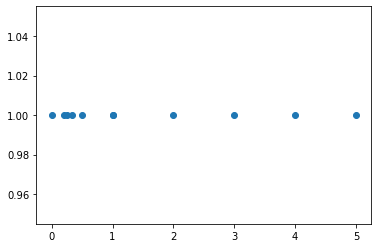

In [102]:
x = np.ones(shape=(12))
y = np.concatenate((x[:6] / np.arange(6), x[6:] * np.arange(6)))
plt.scatter(y, x)

ဒီတော့ balance ညီသွားအောင် $log$ ယူလိုက်တယ်။

/home/edward/anaconda3/envs/py37-dsup/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


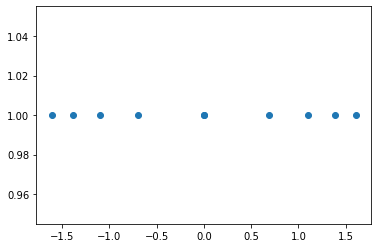

In [103]:
plt.scatter(np.log(y), x)

သတိထားဖို့က ... 

* $log(b^a) = alog(b)$
* $log(ab) = log(a) + log(b)$
* $log(\frac{a}{b}) = log(a) - log(b)$
* $log(1) = 0$ and $log(0)$ is undefined

2. 

In [97]:
plt

<module 'matplotlib.pyplot' from '/home/edward/anaconda3/envs/py37-dsup/lib/python3.7/site-packages/matplotlib/pyplot.py'>